In [1]:
#loading necessary libraries
import numpy as np
import csv

#libraries loaded
print("Libraries loaded!")

Libraries loaded!


In [2]:
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("Data loaded!")

Data loaded!


In [3]:
#augmentation techniques
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

def flip(image):
    return np.fliplr(image)
    
def trans_image(image, steer):
    """ Returns translated image and 
    corrsponding steering angle.
    """
    trans_range = 100
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * 2 * .2
    tr_y = 0
    M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, M, (320,160))
    return image_tr, steer_ang

print('Augmentation techniques added!')

Augmentation techniques added!


In [4]:
import cv2
images = []
measurements = []

for line in lines:
    #source path of center, left and right images
    source_path_center = line[0]
    source_path_left = line[1]
    source_path_right = line[2]
    tokens_center = source_path_center.split('/')
    tokens_left = source_path_left.split('/')
    tokens_right = source_path_right.split('/')
    filename_center = tokens_center[-1]
    filename_left = tokens_left[-1]
    filename_right = tokens_right[-1]
    
    #local path of center, left and right images
    local_path_center = './data/IMG/' + filename_center
    local_path_left = './data/IMG/' + filename_left
    local_path_right = './data/IMG/' + filename_right
    image_center = cv2.imread(local_path_center)
    image_left = cv2.imread(local_path_left)
    image_right = cv2.imread(local_path_right)
    
    #augmenting the images
    image_center_bright = augment_brightness_camera_images(image_center)
    image_left_bright = augment_brightness_camera_images(image_left)
    image_right_bright = augment_brightness_camera_images(image_right)
    image_center_shadow = add_random_shadow(image_center)
    image_left_shadow = add_random_shadow(image_left)
    image_right_shadow = add_random_shadow(image_right)
    image_center_flip = flip(image_center)
    image_center_trans, steering_angle = trans_image(image_center, float(line[3]))
    
    if(len(images)<25000):
        images.append(image_center)
        images.append(image_left)
        images.append(image_right)
        images.append(image_center_bright)
        images.append(image_left_bright)
        images.append(image_right_bright)
        images.append(image_center_shadow)
        images.append(image_left_shadow)
        images.append(image_right_shadow)
        images.append(image_center_flip)
        images.append(image_center_trans)
    
        measurement = float(line[3])
        measurements.append(measurement)
        measurements.append(measurement+0.25)
        measurements.append(measurement-0.25)
        measurements.append(measurement)
        measurements.append(measurement+0.25)
        measurements.append(measurement-0.25)
        measurements.append(measurement)
        measurements.append(measurement+0.25)
        measurements.append(measurement-0.25)
        measurements.append(-measurement)
        measurements.append(steering_angle)
    else:
        break

print("Data stored!")
print("Length images " + str(len(images)))

Data stored!
Length images 25003


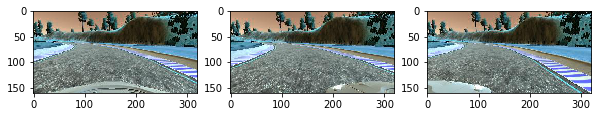

In [5]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

fig = plt.figure(figsize=(10,10))
#center image
plt.subplot(1,3,1)
plt.imshow(images[0])

#left image
plt.subplot(1,3,2)
plt.imshow(images[1])

#right image
plt.subplot(1,3,3)
plt.imshow(images[2])

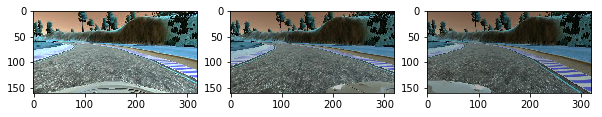

In [6]:
#visualizing augmented bright images

fig = plt.figure(figsize=(10,10))
#center bright image
plt.subplot(1,3,1)
plt.imshow(images[3])

#left bright image
plt.subplot(1,3,2)
plt.imshow(images[4])

#right bright image
plt.subplot(1,3,3)
plt.imshow(images[5])

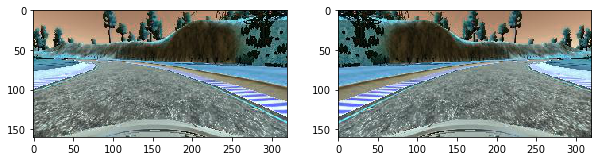

In [7]:
#viewing flipped images

fig = plt.figure(figsize=(10,10))
#original image
plt.subplot(1,2,1)
plt.imshow(images[0])

#flipped image
plt.subplot(1,2,2)
plt.imshow(images[9])

In [8]:
print(measurements[:20])

[0.0, 0.25, -0.25, 0.0, 0.25, -0.25, 0.0, 0.25, -0.25, -0.0, -0.09998884940604938, 0.0, 0.25, -0.25, 0.0, 0.25, -0.25, 0.0, 0.25, -0.25]


In [5]:
#using keras to build the model, model used is end to end deep learning of nvidia
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: (x/255.)-0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((60,25), (50, 50))))
model.add(Convolution2D(24, 5, 5,subsample=(2,2),activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(36, 5, 5,subsample=(2,2),activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(48, 5, 5,subsample=(2,2),activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
print("Model architecture defined!")

Using TensorFlow backend.
/home/arpit/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
/home/arpit/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
/home/arpit/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
/home/arpit/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/arpit/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


Model architecture defined!


In [6]:
#save model for further use
X_train = np.array(images)
y_train = np.array(measurements)
model.fit(X_train, y_train, validation_split=0.25, shuffle=True, nb_epoch=4)

/home/arpit/anaconda/envs/py3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 18752 samples, validate on 6251 samples
Epoch 1/4
18752/18752 [==============================] - 233s - loss: 0.0396 - val_loss: 0.0334
Epoch 2/4
18752/18752 [==============================] - 231s - loss: 0.0337 - val_loss: 0.0315
Epoch 3/4
18752/18752 [==============================] - 230s - loss: 0.0304 - val_loss: 0.0285
Epoch 4/4
18752/18752 [==============================] - 230s - loss: 0.0283 - val_loss: 0.0276


In [16]:
model.save('model.h5')